## I updated the model to HD+PC, using HD to generate directional sweeps which will constantly code the directional to the goal.

In [1]:

import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap, animate_sweeps
from models import HD_cell_L1, PC_cell_L2

#for generting behavioral trajectory
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

#for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr

import os
import time

import sys
sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from core import cl_corr

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

In [6]:
def plot_HDsweep(ax, t, Head_direction, bump_center, max_bump_activity, labelsize=10, ticksize=8):
    ax.plot(t, Head_direction, linewidth=1, color='black', label='Head direction')
    cb = ax.scatter(t, bump_center, c=max_bump_activity, cmap='cool', s=5, label='Internal direction')
    ax.legend(loc='upper center', fontsize=ticksize, bbox_to_anchor=(0.5, 1.4), frameon=False)
    ax.set_ylim(-bm.pi, bm.pi)
    #colorbar
    cbar = plt.colorbar(cb, ax=ax)
    #cbar xlabel
    cbar.set_label('Bump activity', fontsize=ticksize)
    #keep two ticks 
    cbar.set_ticks([np.round(1.01*np.min(max_bump_activity),2), np.round(0.99*np.max(max_bump_activity),2)])
    cbar.ax.tick_params(labelsize=ticksize)
    #xticks
    ax.set_xticks([t[0], t[-1]])
    ax.set_xticklabels([t[0]-t[0], t[-1]-t[0]])
    #yticks
    ax.set_yticks([-bm.pi, 0, bm.pi])
    # ax.set_yticklabels([r'$0\degree$', r'$180\degree$', r'$360\degree$'])
    ax.set_yticklabels([r'$-180\degree$', r'$0\degree$', r'$180\degree$'])
    #label
    ax.set_xlabel('Time (ms)', fontsize=labelsize)
    ax.set_ylabel('Direction', fontsize=labelsize)
    #ticksize
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax


## Section 1: let's first simulated goal-directed directional sweeps in the upstream ring attractor

In [3]:
bm.set_dt(1.)
num_hd = 100
HD_net = HD_cell_L1(num=100, 
                noise_stre=0.1, 
                tau=10., tau_v=100., 
                k=1., mbar=10, a=0.4, A=3., J0=4., #m=20 for adaptation
                z_min=-bm.pi, z_max=bm.pi,
                goal_a=0.4, goal_A=3.0, goal_dir=90/180*bm.pi, topdown=False)

def run_HDNet(i, Head_direction):  # 20 x size
    T_theta = 100 
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    #calculate TheataModulator at time step i
    ThetaModulator_HD = 1+0.5*bm.cos(theta_phase*2*bm.pi)
    # ThetaModulator_HD = 1+0.*bm.cos(theta_phase*2*bm.pi)
    Topdown_mod = 1.0
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod)
    bump_center = HD_net.center
    bump_activity = HD_net.r
    total_input = HD_net.total_input
    return bump_center, bump_activity, total_input

2025-06-19 16:35:35.115508: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  0%|          | 0/4000 [00:00<?, ?it/s]

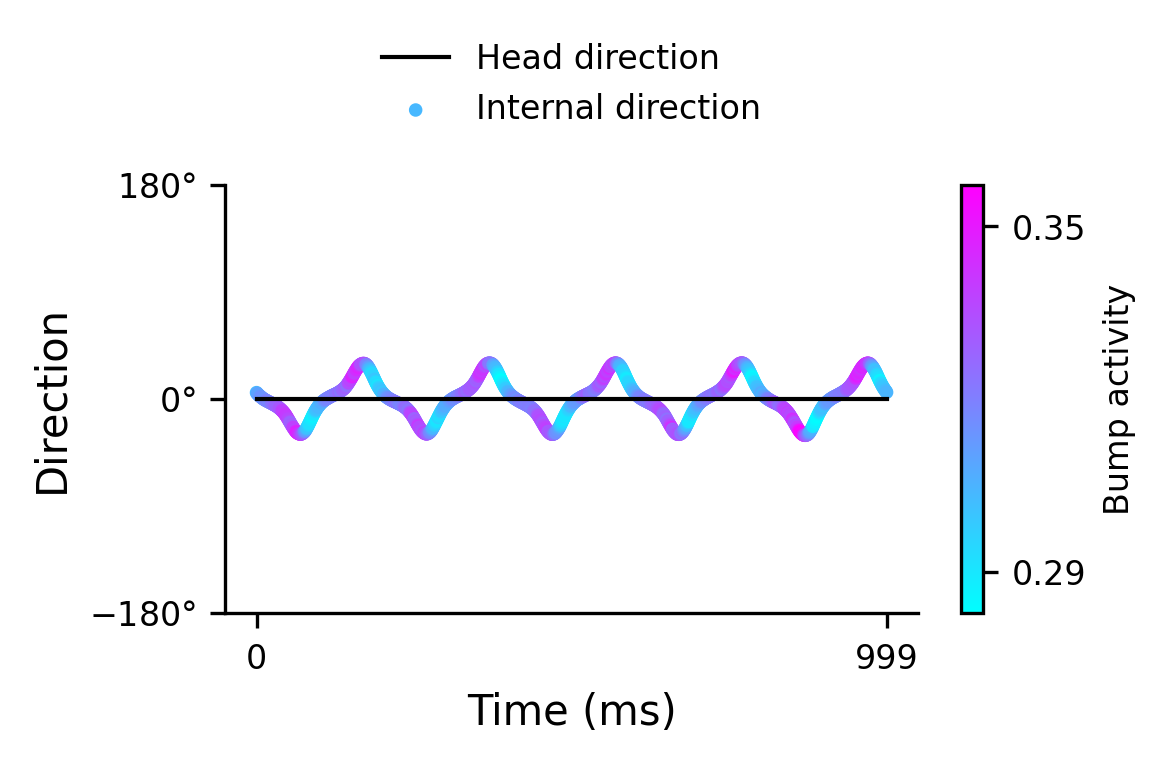

In [4]:
numT = 4000
time_steps = np.arange(numT)
Head_direction = 0.*bm.pi*bm.ones(numT) #fixed head direction, mimicking the animal running in a straight line
bump_center, bump_activity, total_input = bm.for_loop(run_HDNet, (time_steps, Head_direction), progress_bar=True)
max_bump_activity = np.max(bump_activity, axis=1)

start = 2000
end = 3000
#polor

#polor plot in axs[1]
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=300)
ax = plot_HDsweep(ax, 
                  time_steps[start:end], 
                  Head_direction[start:end], 
                  bump_center[start:end], 
                  max_bump_activity[start:end])
plt.tight_layout()


#### check the total input with goal input

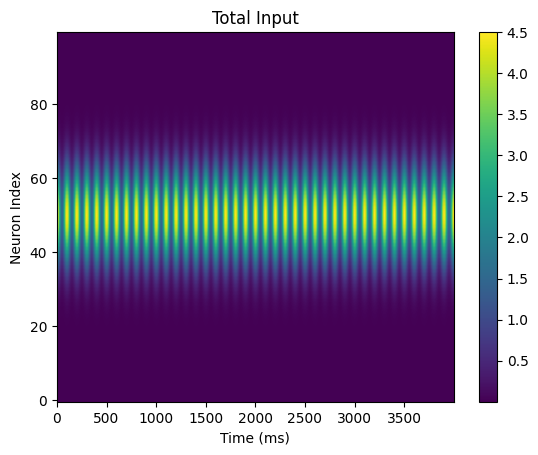

In [5]:
plt.figure()
plt.imshow(total_input.T, aspect='auto', origin='lower')
plt.colorbar()  # optional, adds a colour scale
plt.title('Total Input')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.show()

### animation

MovieWriter Pillow unavailable; using Pillow instead.


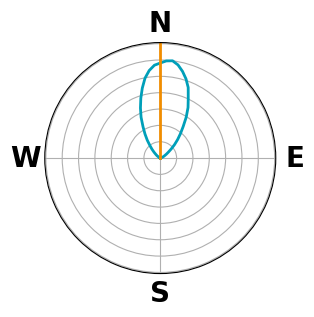

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

start = 1000
end = 4000
x1 = HD_net.x  # assumed to be in radians
ani_data = bump_activity[start:end:10, :]
input_loc = Head_direction[start:end:10]

fig, ax_ani = plt.subplots(1, 1, figsize=(3, 3), dpi=100, subplot_kw={'projection': 'polar'})

ax_ani.set_theta_zero_location('N')  # 0 at the top
ax_ani.set_theta_direction(-1)       # clockwise
ax_ani.set_ylim(0, np.max(ani_data))
ax_ani.set_yticklabels([]) 

ax_ani.set_thetagrids([0, 90, 180, 270], labels=['N', 'E', 'S', 'W'], fontsize=14)

for label in ax_ani.xaxis.get_ticklabels():
    label.set_fontsize(20)
    label.set_fontweight('bold')
    
# create two lines
line1, = ax_ani.plot([], [], color='#009FB9', lw=2)  # tuning curve
line2, = ax_ani.plot([], [], color='#F18D00', lw=2)  # input direction

numframes = ani_data.shape[0]
ylim = np.max(ani_data) * 1.1

def update(i):
    theta = x1  # assumed to be radians from -π to π
    r = ani_data[i].flatten()
    line1.set_data(theta, r)

    # Input line: direction from 0 to max radius
    input_theta = np.array([input_loc[i], input_loc[i]])
    input_radius = np.array([0, ylim])
    line2.set_data(input_theta, input_radius)

    return line1, line2

ani = FuncAnimation(fig, update, frames=numframes, interval=100, blit=False)

ani_filename = '/home/zilong/Desktop/HoneycombSweeps/animations/HD_sweeps_HDfixed.gif'
ani.save(ani_filename, writer='Pillow', fps=10)

# ani.save('./figures/HD_activities_polar.mp4', writer='ffmpeg', fps=10)


## Section 2: Let's assemble the HD ring attractor and the 2D PC attractor together. This model is similar to the grid cell model we published in Curr. Biol., where there is an implicit cogjuntive grid cell layer in between which provides offset input to drive the activity bump in PC net to sweep along that direction. This can be justified as the middle layer which is functioned in grid cell network.

### Section 2.1 Let's first simulate a straight trajectory

In [3]:
def straight_line(x0, v, angle, T):
    x = []
    y = []
    xt = x0
    yt = x0
    for i in range(T):
        # xt = xt + v * bm.cos(angle) * bm.dt
        # yt = yt + v * bm.sin(angle) * bm.dt
        xt = xt + v * np.cos(angle) 
        yt = yt + v * np.sin(angle) 
        x.append(xt)
        y.append(yt)
    Animal_location = np.array([x, y])
    return Animal_location

def circle_period(d):
    d = np.where(d > np.pi, d - 2 * np.pi, d)
    d = np.where(d < -np.pi, d + 2 * np.pi, d)
    return d

# bm.set_platform('gpu')
def get_hd_sweep_features(center_HD, Head_direction, r_HD, start, end):
    '''
    calculate the sweep angle of head direction
    '''
    
    max_hd_activity = np.max(r_HD, axis=1)
    hd_offset = circle_period(center_HD[start:end].reshape(-1)-Head_direction[start:end].reshape(-1))
    #smooth with gaussian filter
    hd_offset = gaussian_filter1d(hd_offset, sigma=10)
    max_fr = gaussian_filter1d(max_hd_activity[start:end], sigma=20)
    #get the peak location
    pks_hdfr, _ = find_peaks(max_fr)
    hd_sweep_angle = hd_offset[pks_hdfr]
    # max_fr = gaussian_filter1d(max_bump_activity[start:end], sigma=20) #sigma=30 more smooth to remove more than two peaks in a cycle
    # pks_hdfr, _ = find_peaks(max_fr)

    #radian to degree
    hd_sweep_angle = np.array([hd_sweep_angle[i]*180/np.pi for i in range(len(hd_sweep_angle))]) 

    return hd_sweep_angle

def get_gc_sweep_features(center_grid, Animal_location, start, end):
    '''
    get the sweep angle of grid cell
    '''    

    dis_x_grid = center_grid[start:end, 0].reshape(-1)-Animal_location[start:end, 0].reshape(-1)
    dis_y_grid = center_grid[start:end, 1].reshape(-1)-Animal_location[start:end, 1].reshape(-1)
    dis_vec = bm.array([dis_x_grid, dis_y_grid])
    moving_vec = bm.array([bm.sqrt(2)/2, bm.sqrt(2)/2]).reshape(1,2)
    projection = bm.matmul(moving_vec, dis_vec).reshape(-1,)

    #smooth with gaussian filter, then seems like no need of calculate the width of the peak
    projection = gaussian_filter1d(projection, sigma=10)

    peaks_grid, _ = find_peaks(projection)
    troughs_grid, _ = find_peaks(-projection)

    num_cycle = peaks_grid.shape[0]

    #calculate sweep angle
    W_rotate = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)], [np.sin(np.pi/4), np.cos(np.pi/4)]])
    Dis = np.array([dis_x_grid, dis_y_grid])
    Dis_rotate = np.matmul(W_rotate, Dis)
    
    Start = Dis_rotate[:, troughs_grid]
    End = Dis_rotate[:, peaks_grid]
    
    gc_sweep_angle = np.zeros(num_cycle)
    
    for i in range(num_cycle):
        gc_sweep_angle[i] = np.arctan((-End[0,i])/(End[1,i]-0))
    

    #radian to degree
    gc_sweep_angle = np.array([gc_sweep_angle[i]*180/np.pi for i in range(len(gc_sweep_angle))]) 

    #norm of dis_vec
    norm_dis = bm.sqrt(dis_x_grid**2 + dis_y_grid**2)
    #smooth with gaussian filter
    norm_dis = gaussian_filter1d(norm_dis, sigma=10)
    peak_dist = norm_dis[peaks_grid]
    trough_dist = norm_dis[troughs_grid]
    
    mean_sweep_length = np.mean(peak_dist)-np.mean(trough_dist)  

    return Dis_rotate, gc_sweep_angle, num_cycle, peak_dist, trough_dist, mean_sweep_length

In [2]:
# simulation time step
bm.set_platform('gpu')
bm.set_dt(1.)

bm.random.seed(0)
np.random.seed(0)


def runNetwork(N = 2, #the animal travel for N*np.pi distance
            mbar_hd = 12., #HD adaptation strength 
            mbar_pc = 5., #GC adaptation strength
            speed_gain = 1.0, #simply treat 1.0 as 1m/s
            noise_stre = 0.,
            v0 = bm.pi*np.sqrt(2)/2/1000, # baseline speed 1m/s
            Phase_Offset = 1.0,
            theta_hd_modulation = 0.4, # default 0.4; maximal 0.4
            theta_gc_modulation = 1.0, # default 0.5; maximal 0.5,
            plot = None):
    
    bm.clear_buffer_memory(platform='gpu')

    bm.set_dt(1.)
    
    Animal_speed = speed_gain*v0
    numT = 4000
    
    #get location, head direction and moving speed
    hd_angle = np.pi / 4
    Animal_location = straight_line(-bm.pi, v=Animal_speed, angle=hd_angle, T=numT)
    Animal_location = Animal_location.transpose()
    Head_direction = hd_angle * bm.ones(numT)  # fixed head direction, mimicking the animal running in a straight line

    #2, input strength modulated by speed, evidence from the Sargolini et al. 2006 paper
    theta_modulation_stre_hd = theta_hd_modulation * speed_gain
    theta_modulation_stre_gc = theta_gc_modulation * speed_gain
    
    #construct the model

    #layer 1
    HD_net = HD_cell_L1(num=100, 
                        noise_stre = noise_stre/10, #gc has muhc more neurons than hd, 10000 vs 100
                        tau=10., 
                        tau_v=100., 
                        k=1., 
                        mbar=mbar_hd, 
                        a=0.4, 
                        A=3., 
                        J0=4., 
                        z_min=-bm.pi, 
                        z_max=bm.pi, 
                        goal_a=0.4, 
                        goal_A=3.0, 
                        goal_dir=135/180*bm.pi, 
                        topdown=True)

    #layer 2
    PC_net = PC_cell_L2(noise_stre = noise_stre,
                        num=100,
                        tau = 10.,
                        tau_v = 100.,
                        mbar = mbar_pc,
                        a = 0.8,
                        A = 8, 
                        J0 = 10.0,
                        k = 1.0,
                        g = 1000,
                        x_min=-bm.pi,
                        x_max=bm.pi,    
                        num_hd = 100,
                        Phase_Offset = Phase_Offset)

    # run coupled net
    def run_CoupleNet(i, Animal_location, Head_direction): 

        T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
        #calculate TheataModulator at time step i for HD and GC
        t = i*bm.dt
        theta_phase = bm.mod(t, T_theta)/T_theta 
        ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
        ThetaModulator_GC = 1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)
        Topdown_mod = 1.0
        
        #calculate internal head direction
        HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod)
        HD_bumpcenter = HD_net.center #center of mass of internal direction
        HD_bumpactivity = HD_net.r 
        # print(HD_activity.shape)
            
        #update the grid cell network 
        PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
        
        #get results
        PC_bumpcenter = PC_net.center_bump
        PC_bumpactivity = PC_net.r
        return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity

    time_steps = np.arange(numT)
    center_grid, center_HD, r_grid, r_HD = bm.for_loop(
        run_CoupleNet, (time_steps, Animal_location, Head_direction), progress_bar=False
    )
    
    
    onecycleT = numT/(N/2)
    # start = int(onecycleT)
    # end = int(numT)

    start = int(numT - 0.9*onecycleT)
    end = int(numT - 0.1*onecycleT)
    
    Results = {}
    # center_grid = center_grid/bm.pi/2
    # Animal_location = Animal_location/bm.pi/2
    
    #get HD sweep features
    hd_sweep_angle = get_hd_sweep_features(center_HD, Head_direction, r_HD, start, end)
    
    #mean of positive - mean of negative
    mean_hd_sweep_angle = (np.mean(hd_sweep_angle[hd_sweep_angle>0]) - np.mean(hd_sweep_angle[hd_sweep_angle<0]))/2
    std_hd_sweep_angle = np.std(np.abs(hd_sweep_angle))
    
    #get GC sweep features
    Dis_rotate, gc_sweep_angle, num_cycle, peak_dist, trough_dist, mean_sweep_length = get_gc_sweep_features(center_grid, Animal_location, start, end)

    mean_gc_sweep_angle = np.mean(np.abs(gc_sweep_angle))
    std_gc_sweep_angle = np.std(np.abs(gc_sweep_angle))
    # print('Grid cell sweep angle:', mean_gc_sweep_angle)
    # print('Grid cell sweep angle std:', std_gc_sweep_angle)
    # print('Grid cell sweep length:', mean_sweep_length)

    if plot=='normalplot':
        fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

        direction_length = 1.2
        max_gc_activity = np.max(r_grid, axis=1)
        
        labelsize = 10
        ticksize = 8

        sc = ax.scatter(
                        Dis_rotate[0,:],
                        Dis_rotate[1,:],
                        c=max_gc_activity[start:end],
                        cmap="cool",
                        s=2,
                        label='Internal location'
        )

        # 添加 x=0 处的直线
        plt.axvline(x=0, color='k')
        # 添加 y=0 处的直线
        plt.axhline(y=0, color='k')
        ax.set_ylim(-0.5, 0.5*np.pi)
        ax.set_xlim(-0.3*np.pi, 0.3*np.pi)

        #add text 'front' at north
        ax.text(0, 0.55*np.pi, 'Front', fontsize=labelsize, ha='center')
        ax.text(-0.45*np.pi, 0, 'Left', fontsize=labelsize, va='center')
        ax.text(0.35*np.pi, 0, 'Right', fontsize=labelsize, va='center')
        
        for i in range(len(hd_sweep_angle)):
            theta = hd_sweep_angle[i]*np.pi/180
            vx1 = direction_length * np.cos(np.pi/2+theta)
            vy1 = direction_length * np.sin(np.pi/2+theta)
            # add arrow edgealpha=0.5, facealpha=0.5
            if i == 0:
                ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='orange', ec='orange', linewidth=1, alpha=0.5, label='Internal direction')
            else:
                ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='orange', ec='orange', linewidth=1, alpha=0.5)
            
        ax.legend(loc='lower center', fontsize=ticksize, frameon=False, bbox_to_anchor=(0.5, -0.2))
        #spines off
        ax.axis('off')
        #equal aspect
        ax.set_aspect('equal')

        plt.tight_layout()
        
    elif plot=='simpleplot':
        fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
        
        direction_length = 1.2
        max_gc_activity = np.max(r_grid, axis=1)
        
        labelsize = 10
        ticksize = 8

        sc = ax.scatter(
                        Dis_rotate[0,:],
                        Dis_rotate[1,:],
                        c=max_gc_activity[start:end],
                        cmap="cool",
                        s=2,
                        label='Internal location'
        )

        # 添加 x=0 处的直线
        plt.axvline(x=0, color='k')
        # 添加 y=0 处的直线
        plt.axhline(y=0, color='k')
        ax.set_ylim(-0.5, 0.5*np.pi)
        ax.set_xlim(-0.4*np.pi, 0.4*np.pi)

        #add text 'front' at north
        ax.text(0, 0.55*np.pi, 'F', fontsize=labelsize, ha='center')
        ax.text(-0.50*np.pi, 0, 'L', fontsize=labelsize, va='center')
        ax.text(0.45*np.pi, 0, 'R', fontsize=labelsize, va='center')
        
        for i in range(len(hd_sweep_angle)):
            theta = hd_sweep_angle[i]*np.pi/180
            vx1 = direction_length * np.cos(np.pi/2+theta)
            vy1 = direction_length * np.sin(np.pi/2+theta)
            # add arrow edgealpha=0.5, facealpha=0.5
            if i == 0:
                ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='orange', ec='orange', linewidth=1, alpha=0.5, label='Internal direction')
            else:
                ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='orange', ec='orange', linewidth=1, alpha=0.5)        
        
        rounded_speed = round(Animal_speed/bm.pi*1000, 1)
        ax.text(0, -0.8, f'Speed: {rounded_speed:.1f}', fontsize=ticksize, ha='center')
        
        ax.axis('off')
        #equal aspect
        ax.set_aspect('equal')

        plt.tight_layout()  
        
    elif plot=='simpleHDplot':
        fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)

        direction_length = 1.2
        max_gc_activity = np.max(r_grid, axis=1)
        
        labelsize = 10
        ticksize = 8
        
        # 添加 x=0 处的直线
        plt.axvline(x=0, color='k')
        # 添加 y=0 处的直线
        plt.axhline(y=0, color='k')
        ax.set_ylim(-0.5, 0.5*np.pi)
        ax.set_xlim(-0.3*np.pi, 0.3*np.pi)

        for i in range(len(hd_sweep_angle)):
            theta = hd_sweep_angle[i]*np.pi/180
            vx1 = direction_length * np.cos(np.pi/2+theta)
            vy1 = direction_length * np.sin(np.pi/2+theta)
            # add arrow edgealpha=0.5, facealpha=0.5
            if i == 0:
                ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='orange', ec='orange', linewidth=1, alpha=0.9)
            else:
                ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='orange', ec='orange', linewidth=1, alpha=0.9)
        
        #remove legend
        ax.legend().set_visible(False)
        #spines off
        ax.axis('off')
        #equal aspect
        ax.set_aspect('equal')

        plt.tight_layout()
        
    elif plot=='twoDplot':
        
        max_r_grid = np.max(r_grid, axis=1) 
        onecycleT = numT/(N/2)
        start = int(numT - 1.0*onecycleT)
        end = int(numT - 0*onecycleT)
        max_bump_activity = np.max(r_HD, axis=1)
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))
        s_size = 2

        ax = axs[0]
        ax.plot(time_steps[start:end], Head_direction[start:end], linewidth=1, color='black')

        cb = ax.scatter(time_steps[start:end], 
                        center_HD[start:end], 
                        c=max_bump_activity[start:end], 
                        cmap='cool', s=s_size)
        ax.set_ylim(-bm.pi, bm.pi)
        #colorbar
        cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
        ax.set_title('Internal direction')

        ax = axs[1]
        ax.set_aspect('equal')
        ax.set_ylim(-bm.pi, bm.pi)
        ax.set_xlim(-bm.pi, bm.pi)
        sc = ax.scatter(
                        center_grid[start:end, 0],
                        center_grid[start:end, 1],
                        c=max_r_grid[start:end],
                        cmap="cool",
                        s=s_size,
        )
        cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        ax.plot(Animal_location[start:end, 0], Animal_location[start:end, 1], color="black")
        ax.set_title('GC bump')

        plt.tight_layout()
             
        
    else:
        fig = None      
    
    Results['hd_sweep_angle'] = hd_sweep_angle
    Results['gc_sweep_angle'] = gc_sweep_angle
    Results['peak_sweep_dist'] = peak_dist
    Results['trough_sweep_dist'] = trough_dist
    Results['mean_hd_sweep_angle'] = mean_hd_sweep_angle
    Results['std_hd_sweep_angle'] = std_hd_sweep_angle
    Results['mean_gc_sweep_angle'] = mean_gc_sweep_angle
    Results['std_gc_sweep_angle'] = std_gc_sweep_angle
    Results['mean_sweep_length'] = mean_sweep_length
    Results['fig'] = fig
    
    
    #save center_grid, center_HD, r_grid, r_HD, numT N time_steps Head_direction Animal_location
    Results['center_grid'] = center_grid
    Results['center_HD'] = center_HD
    Results['r_grid'] = r_grid
    Results['r_HD'] = r_HD
    Results['numT'] = numT
    Results['N'] = N
    Results['time_steps'] = time_steps
    Results['Head_direction'] = Head_direction
    Results['Animal_location'] = Animal_location
    
    return Results


RuntimeError: Unable to initialize backend 'cuda': INTERNAL: no supported devices found for platform CUDA (you may need to uninstall the failing plugin package, or set JAX_PLATFORMS=cpu to skip this backend.)

/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


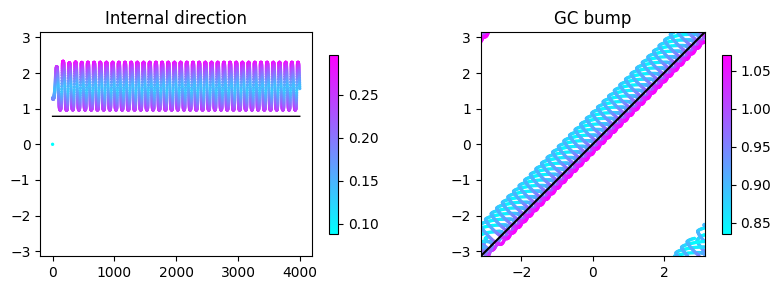

In [ ]:
loaded_results = runNetwork(plot='twoDplot')

### Section 2.2: Let's simulate a real trajectory

In [13]:
# simulation time step
bm.set_platform('gpu')
bm.set_dt(1.)

bm.random.seed(0)
np.random.seed(0)

def discontinuous_plot(ax, x, y, threshold=np.pi, label=None, **kwargs):
    """
    Plot y vs x on ax, breaking the line at discontinuities > threshold.
    Only applies 'label' to the first segment to avoid legend duplication.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.abs(np.diff(y))
    breaks = np.where(dy > threshold)[0] + 1
    segments = np.split(np.column_stack([x, y]), breaks)

    for i, seg in enumerate(segments):
        ax.plot(seg[:, 0], seg[:, 1], label=label if i == 0 else None, **kwargs)

def runNetwork_realtraj(Animal_location_all, Animal_speed_all, Head_direction_all, Dir2Goal_all, goal_loc,
                        v0 = 1.0*bm.pi/1000,  #baseline speed
                        mbar_hd = 5., #HD adaptation strength 
                        mbar_pc = 8., #GC adaptation strength
                        noise_stre = 0.,
                        Phase_Offset = 1.5,
                        theta_hd_modulation = 0.4, # default 0.4; maximal 0.4
                        theta_gc_modulation = 0.2, # default 0.5; maximal 0.5,
                        Topdown_mod = 5.0, # strength of topdown modulation
                        ifplot = False):
    
    bm.clear_buffer_memory(platform='gpu')
    
    #construct the model
    #layer 1
    HD_net = HD_cell_L1(num=100, 
                        noise_stre = noise_stre/10, #gc has muhc more neurons than hd, 10000 vs 100
                        tau=10., 
                        tau_v=100., 
                        k=1., 
                        mbar=mbar_hd, 
                        a=0.4, 
                        A=3., 
                        J0=4., 
                        z_min=-bm.pi, 
                        z_max=bm.pi, 
                        goal_a=0.4, 
                        goal_A=3.0, 
                        topdown=True)

    #layer 2
    PC_net = PC_cell_L2(noise_stre = noise_stre,
                        num=50,
                        tau = 10.,
                        tau_v = 100.,
                        mbar = mbar_pc,
                        a = 0.5,
                        A = 5, 
                        td_A = 5,
                        J0 = 10.0,
                        k = 1.0,
                        g = 1000,
                        x_min=-bm.pi,
                        x_max=bm.pi,    
                        num_hd = 100,
                        Phase_Offset = Phase_Offset)
 

    # run coupled net
    def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
        
        A_modulation = (2+Animal_speed/v0)/3
        theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
        theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

        T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
        #calculate TheataModulator at time step i for HD and GC
        t = i*bm.dt
        theta_phase = bm.mod(t, T_theta)/T_theta 
        ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
        ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
        
        #calculate internal head direction
        HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
        HD_bumpcenter = HD_net.center #center of mass of internal direction
        HD_bumpactivity = HD_net.r 
        # print(HD_activity.shape)
            
        #update the grid cell network 
        PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
        
        #get results
        PC_bumpcenter = PC_net.center_bump
        PC_bumpactivity = PC_net.r
        Input_center = PC_net.center_I
        return PC_bumpcenter, HD_bumpcenter, Input_center, PC_bumpactivity, HD_bumpactivity

    numT = Animal_speed_all.shape[0]
    time_steps = np.arange(numT)
    center_grid, center_HD, center_I, r_grid, r_HD = bm.for_loop(
        run_CoupleNet, (time_steps, Animal_location_all, Head_direction_all, Animal_speed_all, Dir2Goal_all), progress_bar=True
    )
    
    
    Results = {}

    if ifplot:
        
        max_r_grid = np.max(r_grid, axis=1) 
        start=0
        end = numT
        max_bump_activity = np.max(r_HD, axis=1)
        fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
        s_size = 2

        ax = axs[0]
        discontinuous_plot(ax, time_steps[start:end], Head_direction_all[start:end],
                        color='black', linewidth=1, label='HD')

        discontinuous_plot(ax, time_steps[start:end], Dir2Goal_all[start:end],
                        color='red', linewidth=1, label='Dir2Goal')
        
        
        ax.legend()
        
        cb = ax.scatter(time_steps[start:end], 
                        center_HD[start:end], 
                        c=max_bump_activity[start:end], 
                        cmap='cool', s=s_size)
        ax.set_ylim(-bm.pi, bm.pi)
        #colorbar
        cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
        ax.set_title('Direction sweeps')

        ax = axs[1]
        ax.set_aspect('equal')
        ax.set_ylim(-bm.pi, bm.pi)
        ax.set_xlim(-bm.pi, bm.pi)
        sc = ax.scatter(
                        center_grid[start:end, 0],
                        center_grid[start:end, 1],
                        c=max_r_grid[start:end],
                        cmap="cool",
                        s=s_size,
        )
        
        # sc = ax.scatter(
        #                 center_I[start:end, 0],
        #                 center_I[start:end, 1],
        #                 c='red',
        #                 s=s_size,
        # )
        # cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
        
        # ax.plot(Animal_location_all[:, 0], Animal_location_all[:, 1], color="black")
        
        traj_times = np.arange(len(Animal_location_all))
        sc_traj = ax.scatter(Animal_location_all[:, 0], 
                            Animal_location_all[:, 1], 
                            c=traj_times, 
                            cmap='gray', 
                            s=1, 
                            label='Trajectory (time-coded)')
   
        cbar_traj = plt.colorbar(sc_traj, ax=ax, shrink=0.8)
        cbar_traj.set_label('Time (steps)')   
        
        ax.plot(goal_loc[0], goal_loc[1], marker='*', color='orange', markersize=10, label='Goal location')
        
        ax.set_title('Position sweeps')

        plt.tight_layout()
             
        
    else:
        fig = None      

    Results['fig'] = fig
    #save center_grid, center_HD, r_grid, r_HD, numT N time_steps Head_direction Animal_location
    Results['center_grid'] = center_grid
    Results['center_HD'] = center_HD
    Results['r_grid'] = r_grid
    Results['r_HD'] = r_HD
    Results['numT'] = numT
    Results['time_steps'] = time_steps
    Results['Head_direction'] = Head_direction_all
    Results['Animal_location'] = Animal_location_all
    Results['Animal_speed'] = Animal_speed_all
    
    return Results


In [3]:


def generate_trajectory(Animal_ave_speed, goal_loc, dur, ifplot):

    x1 = -np.pi/2
    x2 = np.pi/2

    Env = Environment(params={
        'scale':x2-x1,
        "dimensionality": "2D",
    })

    # Animal_ave_speed = np.sqrt(2)*bm.pi/2/1000  #vary this to change the speed of the animal

    dt = 0.001 #s
    speed_mean = Animal_ave_speed*1e3 #m/s
    rotation_velocity_std = 80*np.pi/180 #radians
    speed_std = 0. #in m/ms

    Ag = Agent(Env, params = {
        "dt": dt,
        "speed_mean":speed_mean,
        "speed_std": speed_std,
        "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
        })

    while Ag.t < dur:
        Ag.update()
        
    Position = Ag.history['pos']
    HeadDirection = Ag.history['head_direction']
    # Velocity = Ag.history['vel']

    Position = np.array(Position) + x1

    diff = np.diff(Position, axis=0)
    
    Velocity = np.zeros_like(Position)

    Velocity[:-1, :] = diff

    # Velocity = np.array(Velocity)
    Moving_speed = np.linalg.norm(Velocity, axis=1)
    HeadDirection = np.array(HeadDirection)
    # 将 HeadDirection 转换为复数
    complex_numbers = HeadDirection[:, 0] + 1j * HeadDirection[:, 1]
    # 计算复数的幅角
    HD_angle = np.angle(complex_numbers)
    
    #calculate direction to the goal WRONF VERSION!! We need an allocentrci direction 2 goal, see below
    # vec_to_goal = goal_loc - Position
    # vec_to_goal_norm = vec_to_goal / np.linalg.norm(vec_to_goal, axis=1, keepdims=True)

    # # Compute dot and cross product
    # dot = np.einsum('ij,ij->i', HeadDirection, vec_to_goal_norm)
    # cross = HeadDirection[:, 0] * vec_to_goal_norm[:, 1] - HeadDirection[:, 1] * vec_to_goal_norm[:, 0]

    # # Compute signed angular difference
    # Dir2Goal = np.arctan2(cross, dot)  # in radians, signed, goal on the right is positive, and on the left is negative
    
    #Correct version
    vec_to_goal = goal_loc - Position  # shape: (N, 2)
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])  # angle in radians ∈ (−π, π]

    if ifplot == True:
        min_angle_idx = np.argmin(np.abs(Dir2Goal))
        min_pos = Position[min_angle_idx]
        
        #plot Position
        fig, ax = plt.subplots(1,3,figsize=(9,3))
        
        ax[0].plot(Position[:,0], Position[:,1])
        ax[0].set_xlim(-np.pi, np.pi)
        ax[0].set_ylim(-np.pi, np.pi)
        
        ax[0].plot(min_pos[0], min_pos[1], 'ro', markersize=6, label='Best alignment')
        ax[0].plot(goal_loc[0], goal_loc[1], marker='*', color='orange', markersize=10, label='Goal location')
        
        # ax[0].axis('equal')   
        ax[0].set_title('Animal location')

        ax[1].plot(Moving_speed)
        ax[1].set_title('Moving speed')
        ax[2].plot(HD_angle)
        ax[2].set_title('Head-direction angle')
        plt.tight_layout()
        
    # Find time steps where head direction is most aligned to goal direction
    min_angle_idx = np.argmin(np.abs(Dir2Goal))
    print(f"Minimum absolute Dir2Goal: {Dir2Goal[min_angle_idx]:.4f} rad at t = {min_angle_idx}")

    # # Also print the dot product at that index (should be close to 1 if aligned)
    # dot_product = np.dot(HeadDirection[min_angle_idx], vec_to_goal_norm[min_angle_idx])
    # print(f"Dot product at that time: {dot_product:.4f}")

    return Position, Moving_speed, HD_angle, Dir2Goal, Velocity



Minimum absolute Dir2Goal: 1.5905 rad at t = 135


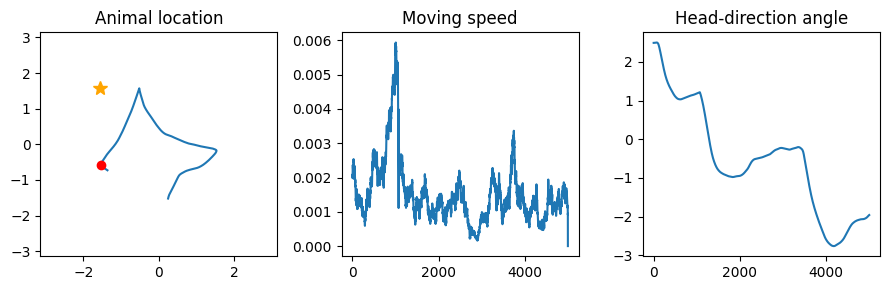

In [15]:
np.random.seed(223112)

goal_loc = (-0.5*np.pi, 0.5*np.pi)
Animal_location_all, Animal_speed_all, Head_direction_all, Dir2Goal_all, Animal_Vel_all = generate_trajectory(Animal_ave_speed= np.sqrt(2)*bm.pi/2/1000, 
                                                                              goal_loc = goal_loc, 
                                                                              dur=5, 
                                                                              ifplot=True)


In [16]:
Animal_speed_all.max()

0.005938060120724749

  0%|          | 0/5000 [00:00<?, ?it/s]

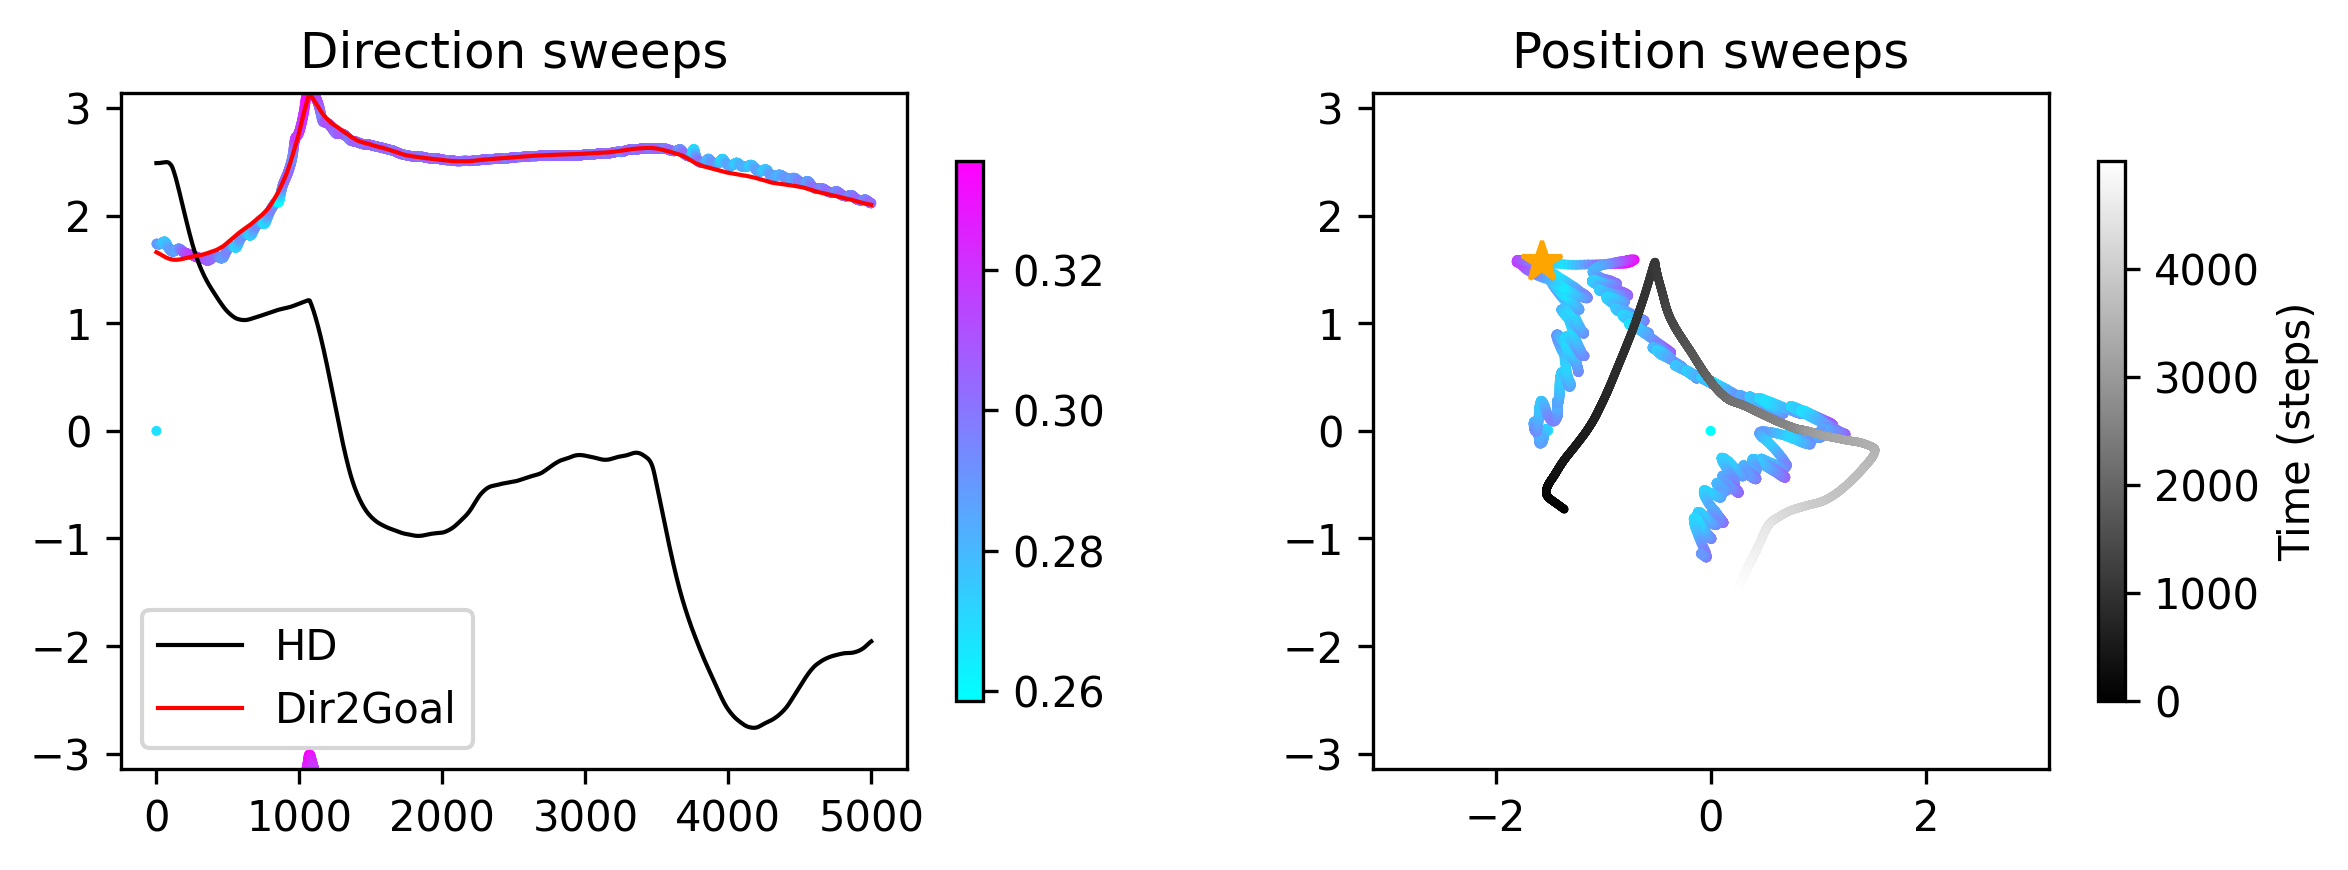

In [11]:
results =  runNetwork_realtraj(Animal_location_all, Animal_speed_all, Head_direction_all, Dir2Goal_all, goal_loc, ifplot=True)

In [ ]:
#animate the sweeps and save the animation
pc_activity = results['r_grid'].reshape(-1,50,50)
num = 50
duration = len(Animal_location_all)
Speed = results['Animal_speed']
m0 = 2
z_max = np.pi

print('Animating...')


save_path = './animations/'
filename_prefix = 'twolayer_'
animate_sweeps(Animal_location_all, pc_activity, num, duration, Speed, m0, z_max, n_step=10, goal_loc=goal_loc, save_path=save_path, filename_prefix=filename_prefix)

MovieWriter imagemagick unavailable; using Pillow instead.


Animating...
Animation saved to ./animations/twolayer_2.gif


## Section 3: Let's run a long trajectory and simulate the network and also do analysis

Minimum absolute Dir2Goal: 0.0036 rad at t = 25701


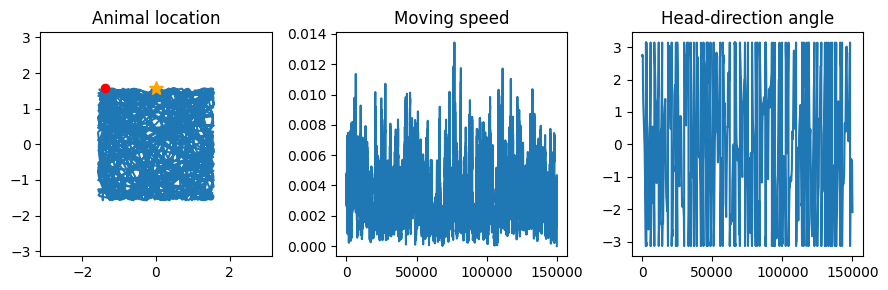

In [4]:
np.random.seed(111)

goal_loc = (-0.*np.pi, 0.5*np.pi)
Animal_location_all, Animal_speed_all, Head_direction_all, Dir2Goal_all, Animal_Vel_all = generate_trajectory(Animal_ave_speed= 2*np.sqrt(2)*bm.pi/2/1000, 
                                                                              goal_loc = goal_loc, 
                                                                              dur=150, 
                                                                              ifplot=True)


(array([2.2555e+04, 4.4755e+04, 3.7573e+04, 2.4074e+04, 1.2516e+04,
        5.8040e+03, 2.0050e+03, 5.6500e+02, 1.2800e+02, 2.5000e+01]),
 array([0.        , 0.00134306, 0.00268612, 0.00402918, 0.00537223,
        0.00671529, 0.00805835, 0.00940141, 0.01074447, 0.01208753,
        0.01343059]),
 <BarContainer object of 10 artists>)

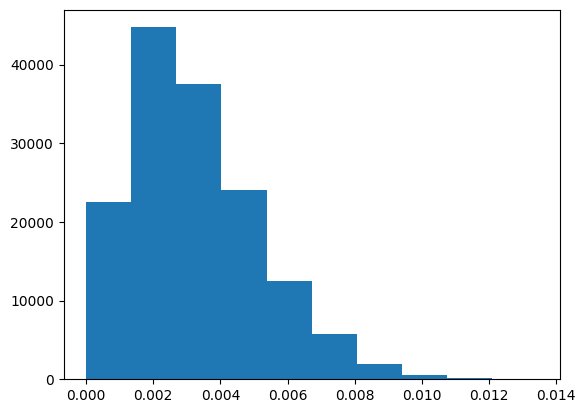

In [19]:
plt.hist(Animal_speed_all)

In [5]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 5. #HD adaptation strength 
mbar_pc = 8. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.5
theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0.2 # default 0.5; maximal 0.5,
Topdown_mod = 5.0 # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=True)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 0.5,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], 
                                                                                                        Animal_location_all[i:i+simulate_time], 
                                                                                                        Head_direction_all[i:i+simulate_time],
                                                                                                        Animal_speed_all[i:i+simulate_time],
                                                                                                        Dir2Goal_all[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

2025-06-25 11:35:47.045057: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%
Simulation progress: 33%
Simulation progress: 67%


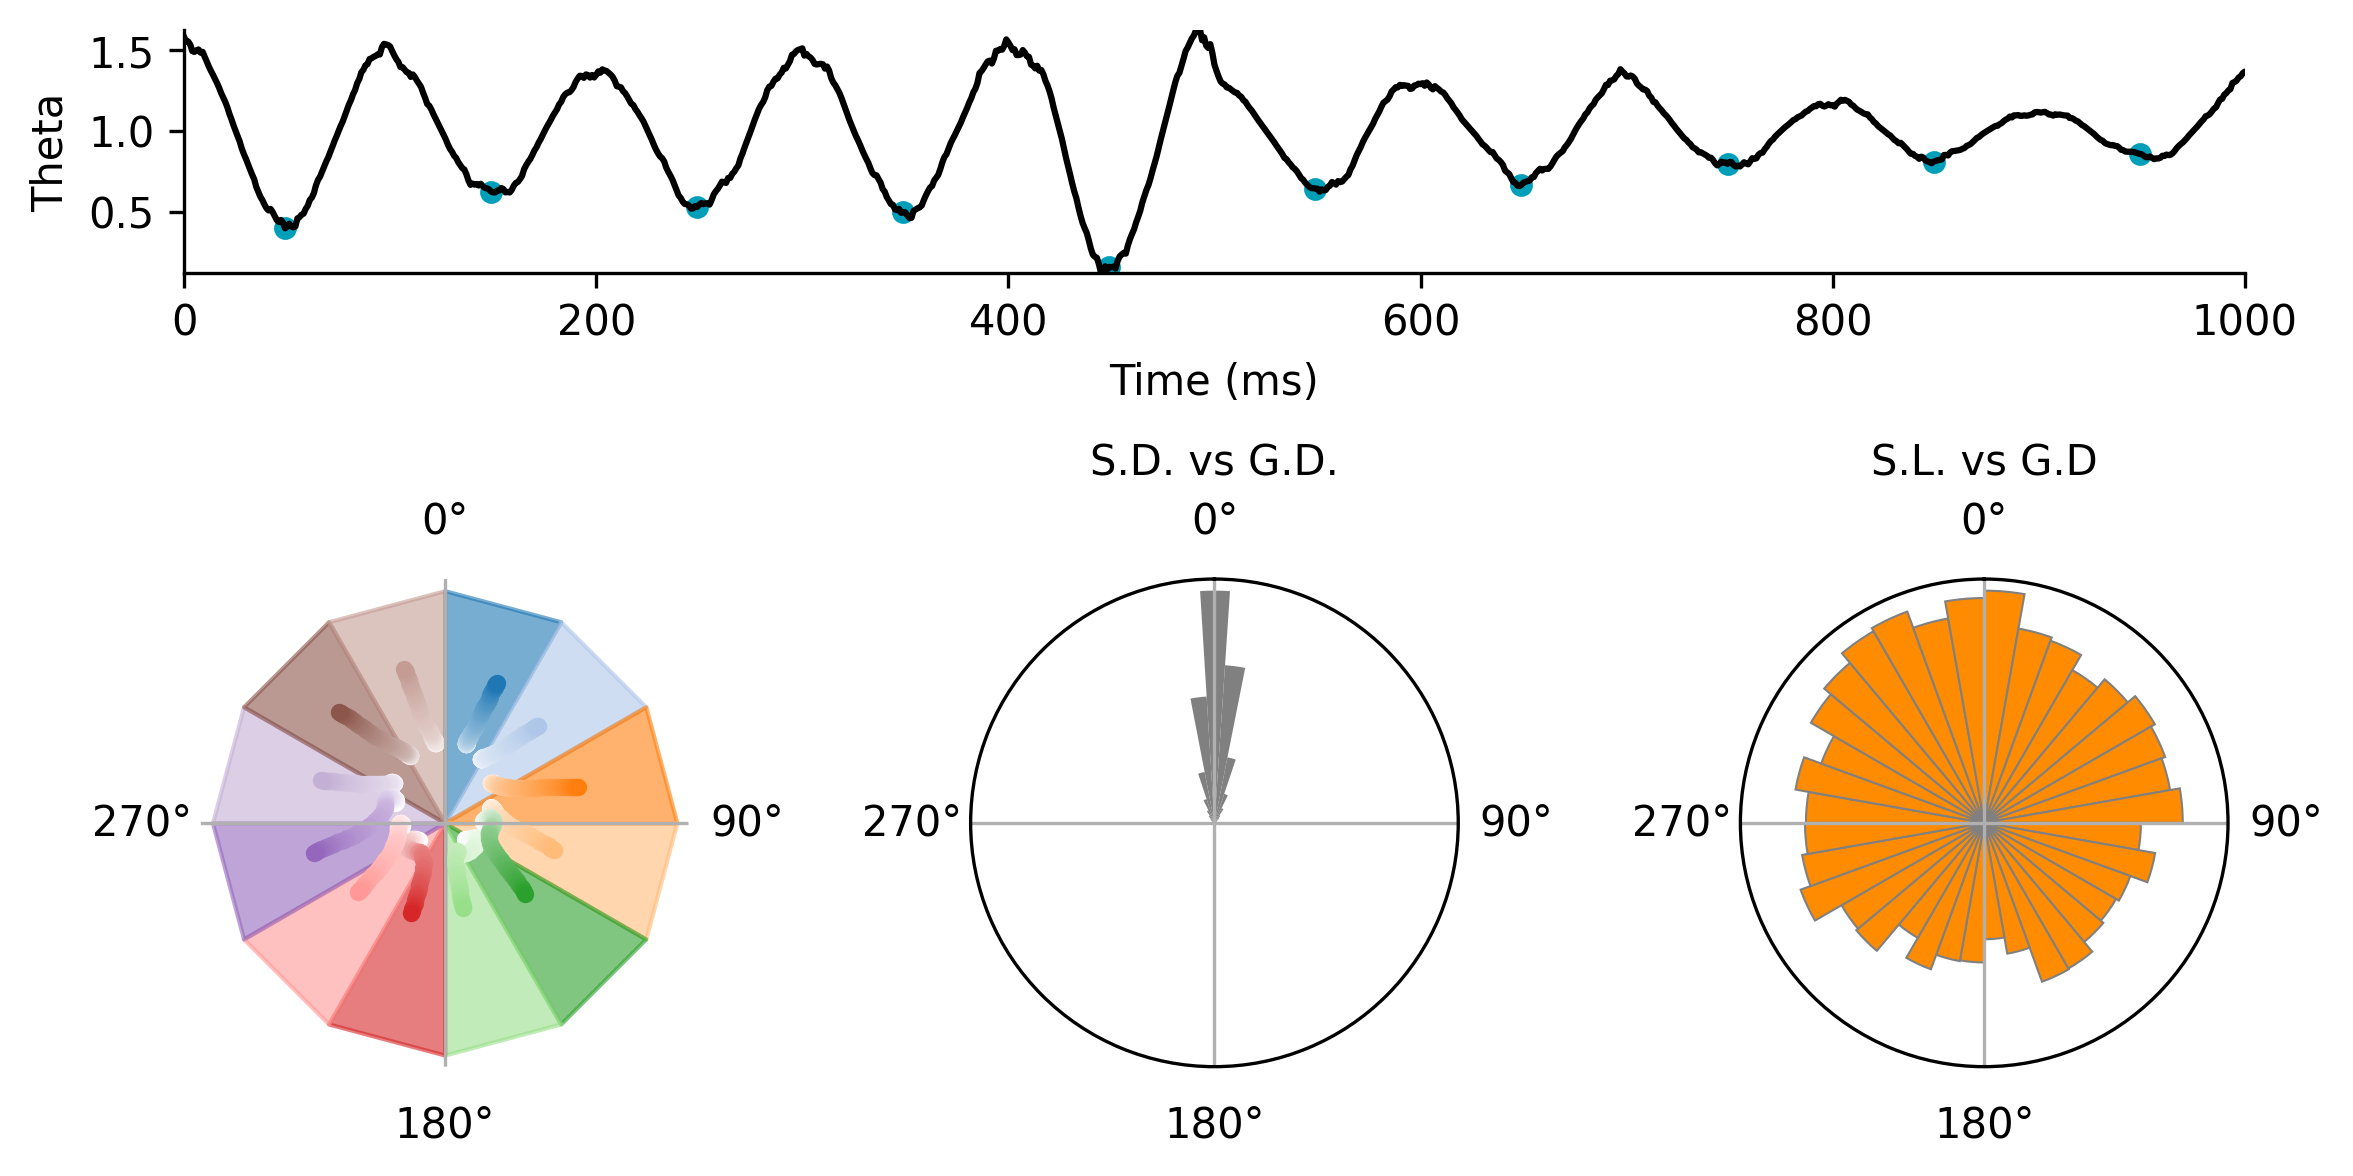

In [9]:

def create_custom_trajectory_cmap(target_color):
    """
    Create a colormap that transitions from white to the target color.

    Parameters
    ----------
    target_color : tuple or str
        A colour accepted by matplotlib (e.g., an RGB/RGBA tuple or a named string)

    Returns
    -------
    LinearSegmentedColormap
        A custom colormap object
    """
    return LinearSegmentedColormap.from_list('custom_cmap', ['white', target_color])


start = 10; end = 60 #extract a middle period as Changmin did in empirical data analysis. He used 15°-195° in 360°, so we used 5-55 in 100. 
num = 50
z_max = np.pi

#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase)
peaks -= 50 #get the trough!!! So that we plot the averaged sweeps like Changmin did in his lateset analysis where he used MUA
# troughs, _ = find_peaks(-theta_phase)       # for minima

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(8, 4), dpi=300)
gs = gridspec.GridSpec(2, 3, height_ratios=(1,2))

ax = plt.subplot(gs[0,:])
ax.plot(theta_rhythm, color='black')
ax.scatter(peaks, theta_rhythm[peaks], color='#009FB9', s=20)
# ax.scatter(troughs, theta_rhythm[troughs], color='blue', s=20)
ax.set_xlim(0, 1000)
ax.set_ylim(np.min(theta_rhythm[:1000]), np.max(theta_rhythm[:1000]))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta')
sns.despine()

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dimension as Angle_at_zeroPhase

BumpAngle_at_all_phase = []
BumpDist_2_pos = []
SweepLength = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - Animal_location_all[peaks[i], 0], goal_loc[1] - Animal_location_all[peaks[i], 1]])
    #calculate the angle between vec and moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[peaks[i], 1], Animal_Vel_all[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]       #/num * z_max
    
    # sweep_length = np.linalg.norm(bumpTraj_in_Acycle[start,:] - bumpTraj_in_Acycle[end,:])
    # sweep_length = np.linalg.norm(Animal_location_all[peaks[i], :] - bumpTraj_in_Acycle[end,:])
    
    # start_point = bumpTraj_in_Acycle[start, :]
    # # start_point = Animal_location_all[peaks[i], :]
    # distances = np.linalg.norm(bumpTraj_in_Acycle - start_point, axis=1)
    # sweep_length = np.max(distances)

    pos_in_Acycle = Animal_location_all[peaks[i]:peaks[i+1], :]
    # start_point = Animal_location_all[peaks[i], :]
    distances = np.linalg.norm(bumpTraj_in_Acycle - pos_in_Acycle, axis=1)
    sweep_length = np.max(distances)
    
    SweepLength.append(sweep_length)
    
    BumpAngle = []
    BumpDist = []
    
    for j in range(len(bumpTraj_in_Acycle)):
        
        #calculate the angle between sweeps and Position at the peak (zero phase)
        # vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Animal_location_all[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Animal_location_all[peaks[i], 1]])
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - pos_in_Acycle[j, 0], bumpTraj_in_Acycle[j, 1] - pos_in_Acycle[j, 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec[1], vec[0])
        angel2 = np.degrees(angle2) % 360
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Animal_Vel_all[peaks[i], 1], Animal_Vel_all[peaks[i], 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        # dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
        
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpDist_2_pos.append(BumpDist)

####################################################################################################

ax = plt.subplot(gs[1, 0], projection='polar')
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
# ax.set_ylim(0, 0.2)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1.0, color=colors[i], alpha=0.6)

scatter_angles = []
scatter_distances = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist))

#in each angular bin, calculate the mean sweep angle and distance
for key in sweep_info:
    sweep_info_key = sweep_info[key]
    SA = []
    SD = []
    for sweep_angs, sweep_dist in sweep_info_key:
        SA.append(sweep_angs[start:end])
        SD.append(sweep_dist[start:end])
        
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    
    # Get target color
    custom_cmap = create_custom_trajectory_cmap(colors[key])
    n_steps = len(SA_mean)
    gradient_colors = custom_cmap(np.linspace(0.0, 1.0, n_steps) ** 1.0)
    
    for i, (ang, dist) in enumerate(zip(SA_mean, SD_mean)):
        scatter_angles.append(np.radians(ang))
        scatter_distances.append(dist)

        scatter_colors.append(gradient_colors[i])  # white → full colour transition
        scatter_alphas.append(1.0)  # fully opaque

    # Generate gradient colours from white → target_color
    n_steps = len(SA_mean)
    gradient_colors = custom_cmap(np.linspace(0.0, 1.0, n_steps))


#plot mean sweep angle and distance in each angular bin
for i in range(len(scatter_angles)):
    ax.scatter(scatter_angles[i], scatter_distances[i], color=scatter_colors[i], s=10, alpha=scatter_alphas[i])

####################################################################################################

ax = plt.subplot(gs[1, 1], projection='polar') 
ax.hist(BumpAngle_2_goal, bins=72, color='grey')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_title('S.D. vs G.D.', fontsize=10)

####################################################################################################

ax = plt.subplot(gs[1, 2], projection='polar') 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
# Convert angles to radians in range [0, 2π)
angles_rad = np.radians(np.array(Angle_at_zeroPhase) % 360)
sweep_lengths = np.array(SweepLength)

# Define bin edges (72 bins of 5 degrees)
n_bins = 36
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)

# Digitise the angle data into bins
bin_indices = np.digitize(angles_rad, bin_edges) - 1  # subtract 1 to make indices 0-based

# Initialise array to store average sweep lengths
avg_sweep_length = np.zeros(n_bins)
for i in range(n_bins):
    in_bin = sweep_lengths[bin_indices == i]
    if len(in_bin) > 0:
        avg_sweep_length[i] = np.mean(in_bin)
    else:
        avg_sweep_length[i] = 0.0  # or np.nan if you prefer

# Prepare angles for bar centres
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as polar histogram (bar plot)
ax.bar(bin_centres, avg_sweep_length, width=(2 * np.pi / n_bins), bottom=0.0, color='darkorange', edgecolor='grey', linewidth=0.5)

# Format
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
ax.set_title('S.L. vs G.D', fontsize=10)


plt.tight_layout()

# plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/test.pdf')

## Section 4, check theta phase precession

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def find_periods(Position, goal_loc, threshold=1000):
    """
    Finds continuous periods where the distance to goal_loc is either decreasing or increasing 
    for at least `threshold` points.

    Parameters:
    - Position (ndarray): Array of positions (Nx2 or Nx3 for 2D or 3D positions).
    - goal_loc (ndarray): Goal location as an array (2D or 3D).
    - threshold (int): Minimum length of a continuous period to consider.

    Returns:
    - decreasing_periods (list): List of tuples (start_index, end_index) for valid decreasing periods.
    - increasing_periods (list): List of tuples (start_index, end_index) for valid increasing periods.
    """
    decreasing_periods = []
    increasing_periods = []
    current_start = None
    decreasing_count = 0
    increasing_count = 0
    mode = None  # Tracks whether we're in a decreasing or increasing phase

    for i in range(1, len(Position)):
        dist_prev = np.linalg.norm(Position[i-1] - goal_loc)
        dist_curr = np.linalg.norm(Position[i] - goal_loc)

        if dist_curr < dist_prev:  # Distance is decreasing
            if mode != "decreasing":
                # End previous increasing period
                if increasing_count >= threshold:
                    increasing_periods.append((current_start, current_start + increasing_count))
                current_start = i - 1
                increasing_count = 0
                mode = "decreasing"
            decreasing_count += 1
        elif dist_curr > dist_prev:  # Distance is increasing
            if mode != "increasing":
                # End previous decreasing period
                if decreasing_count >= threshold:
                    decreasing_periods.append((current_start, current_start + decreasing_count))
                current_start = i - 1
                decreasing_count = 0
                mode = "increasing"
            increasing_count += 1
        else:
            # Distance is constant or ambiguous, reset counters and handle ending periods
            if mode == "decreasing" and decreasing_count >= threshold:
                decreasing_periods.append((current_start, current_start + decreasing_count))
            elif mode == "increasing" and increasing_count >= threshold:
                increasing_periods.append((current_start, current_start + increasing_count))
            current_start = None
            decreasing_count = 0
            increasing_count = 0
            mode = None

    # Final check after the loop ends
    if mode == "decreasing" and decreasing_count >= threshold:
        decreasing_periods.append((current_start, current_start + decreasing_count))
    elif mode == "increasing" and increasing_count >= threshold:
        increasing_periods.append((current_start, current_start + increasing_count))

    return decreasing_periods, increasing_periods


def restrict_periods_to_field(periods, positions, cx, cy, radius, min_length=10):
    """
    From each (start, end) period, extract all subsegments where position stays inside circle.

    Parameters
    ----------
    periods : list of (start, end)
    positions : (N, 2) array
    cx, cy : float
        Centre of the circle
    radius : float
        Radius of the field
    min_length : int
        Minimum duration (in samples) for a subperiod to keep

    Returns
    -------
    restricted_periods : list of (sub_start, sub_end)
    """
    restricted = []

    for start, end in periods:
        segment = positions[start:end+1]
        dists = np.sqrt((segment[:, 0] - cx) ** 2 + (segment[:, 1] - cy) ** 2)
        inside = dists <= radius

        # Find continuous chunks where inside == True
        i = 0
        while i < len(inside):
            if inside[i]:
                sub_start = i
                while i < len(inside) and inside[i]:
                    i += 1
                sub_end = i - 1
                if (sub_end - sub_start + 1) >= min_length:
                    restricted.append((start + sub_start, start + sub_end))
            else:
                i += 1

    return restricted




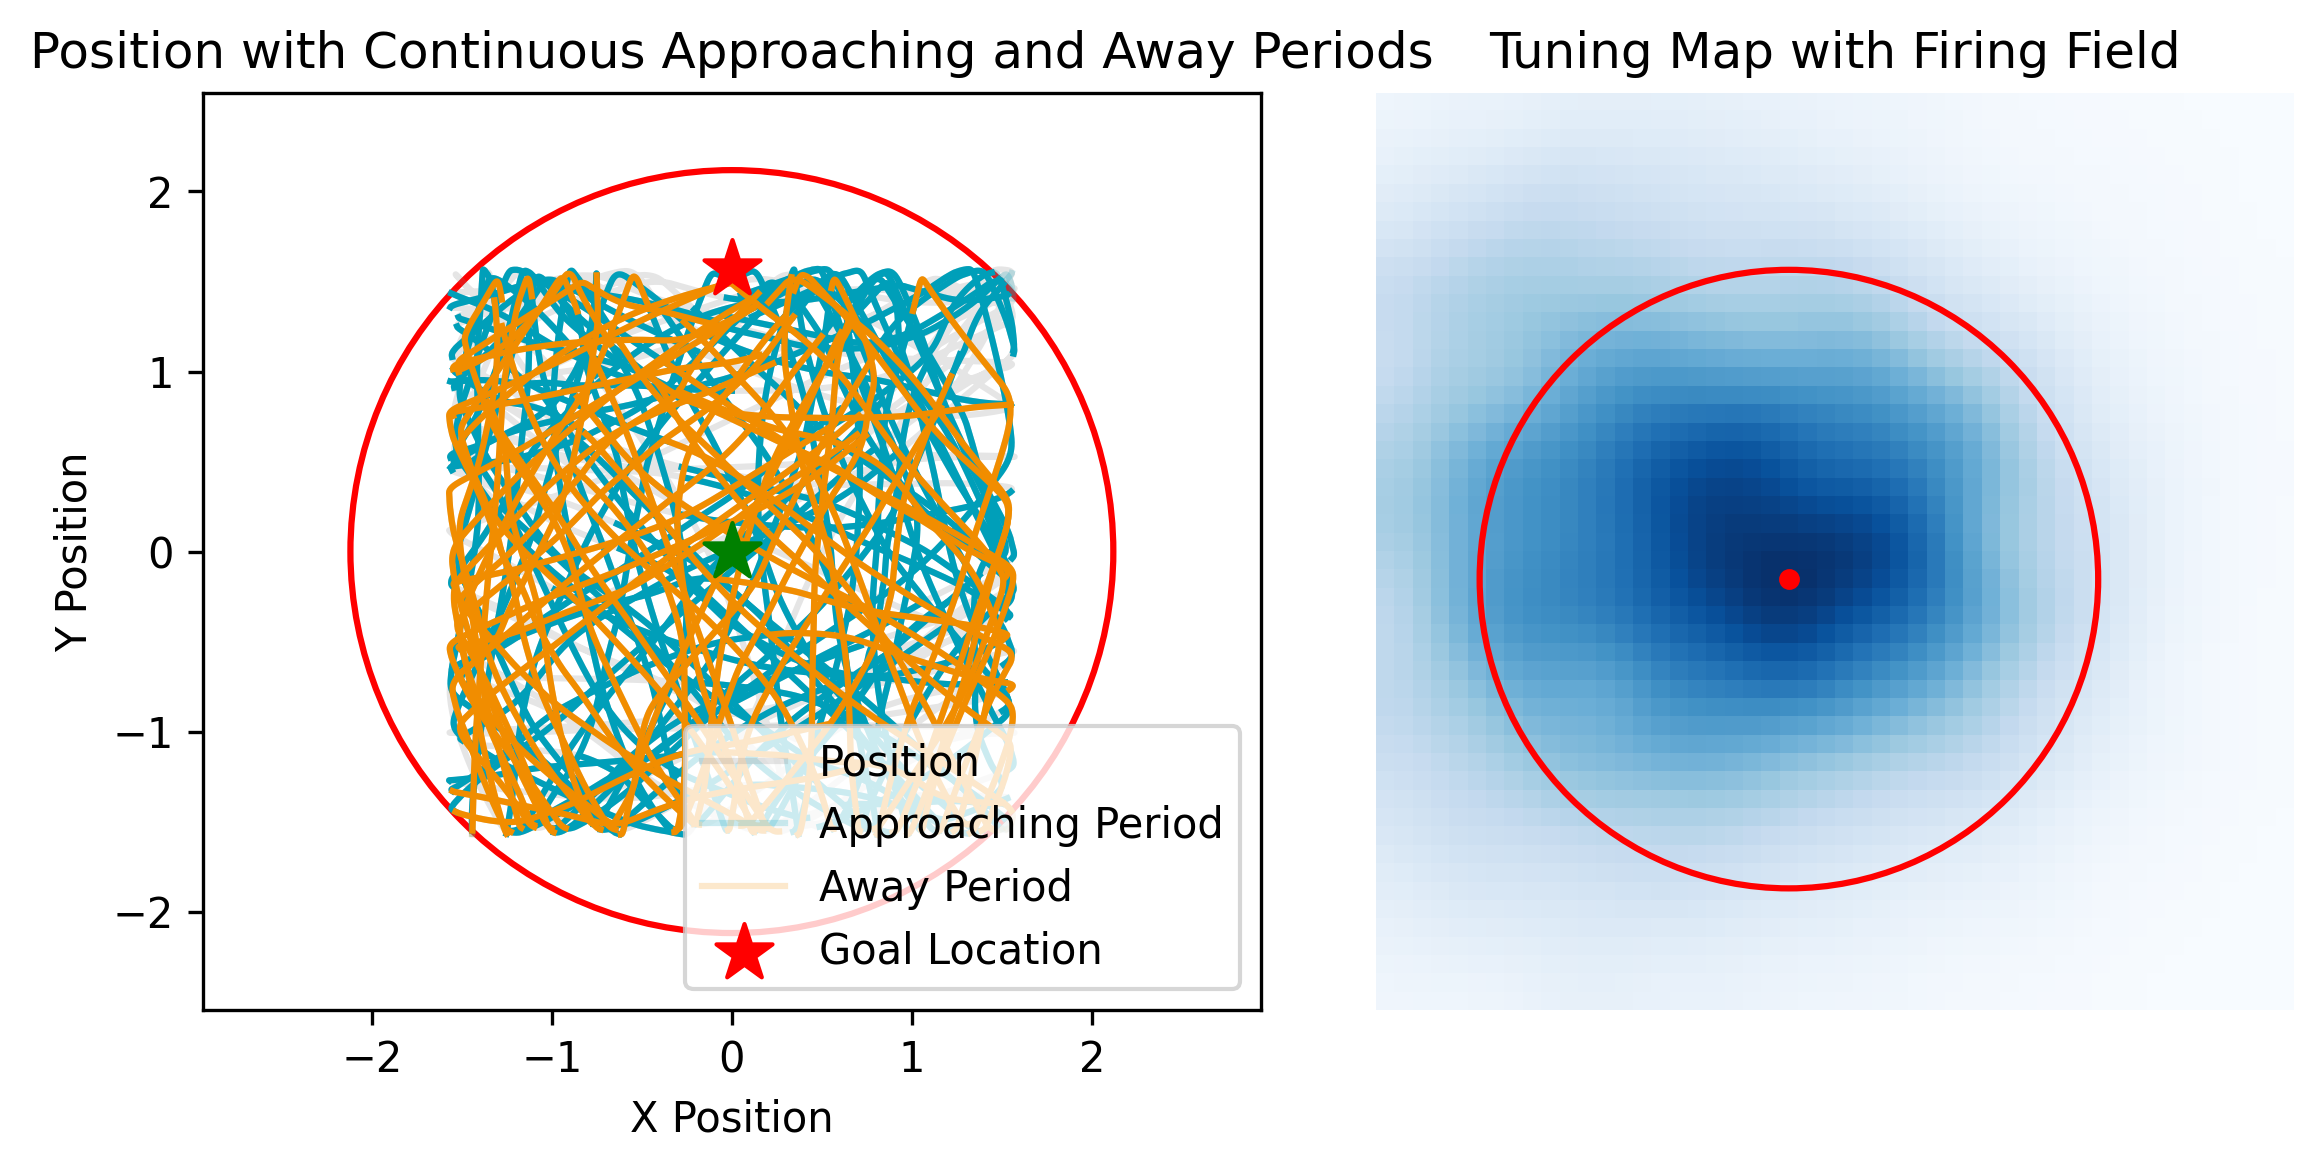

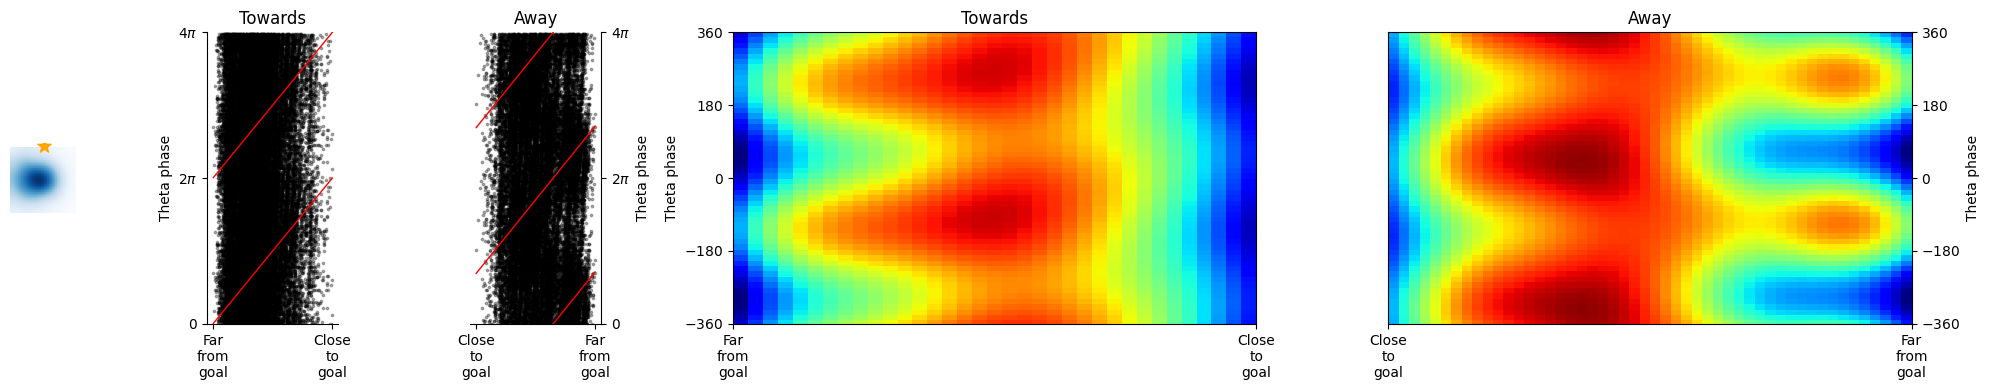

In [12]:
# Example usage:
decreasing_periods, increasing_periods = find_periods(Animal_location_all, goal_loc, threshold=500)

fig, axs = plt.subplots(1,2,figsize=(8, 4), dpi=300)

ax = axs[0]
# Plot all positions in grey
ax.plot(Animal_location_all[:, 0], Animal_location_all[:, 1], color='grey', label='Position', alpha = 0.2)

# Highlight decreasing (approaching) periods in blue
for start, end in decreasing_periods:
    ax.plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#009FB9',
        label='Approaching Period' if start == decreasing_periods[0][0] else "",
        alpha = 0.2
    )

# Highlight increasing (away) periods in orange
for start, end in increasing_periods:
    ax.plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#F18D00',
        label='Away Period' if start == increasing_periods[0][0] else "",
        alpha = 0.2
    )

# Mark goal location
ax.scatter(goal_loc[0], goal_loc[1], color='red', marker='*', label='Goal Location', zorder=5, s=200)

# Formatting
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Position with Continuous Approaching and Away Periods')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.legend()
ax.axis('equal')

ax = axs[1]

cellindex = [25, 25]

#tuning map of a cell

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')

# Smooth the tuning map if needed
tuningMap_smooth = gaussian_filter(tuningMap, sigma=1)

# Get peak location
peak_y, peak_x = np.unravel_index(np.nanargmax(tuningMap_smooth), tuningMap.shape)

# Compute radius based on 30% peak
threshold = 0.05 * np.nanmax(tuningMap_smooth)
mask = tuningMap_smooth >= threshold
y_idx, x_idx = np.where(mask)
distances = np.sqrt((x_idx - peak_x)**2 + (y_idx - peak_y)**2)
mean_radius = np.mean(distances)

# Plot on axs[1]
axs[1].imshow(tuningMap_smooth, cmap='Blues', origin='lower')
circle = plt.Circle((peak_x, peak_y), mean_radius, color='red', fill=False, linewidth=1.5)
axs[1].add_patch(circle)
axs[1].plot(peak_x, peak_y, 'ro', markersize=4)
axs[1].set_title('Tuning Map with Firing Field')
axs[1].axis('off')


#add this cycle to ax[0], center is x = cellindex[0]/50*2*np.pi-np.pi, y = cellindex[1]/50*2*np.pi-np.pi
cx = cellindex[0]/50*2*np.pi-np.pi
cy = cellindex[1]/50*2*np.pi-np.pi
axs[0].scatter(cx, cy, color='green', marker='*', label='Field center', zorder=5, s=200)
real_radius = mean_radius/num*2*np.pi
circle = plt.Circle((cx, cy), real_radius, color='red', fill=False, linewidth=1.5)
axs[0].add_patch(circle)

# Apply restriction using computed circle
decreasing_periods_field = restrict_periods_to_field(decreasing_periods, Animal_location_all, cx, cy, real_radius)
increasing_periods_field = restrict_periods_to_field(increasing_periods, Animal_location_all, cx, cy, real_radius)

# Highlight decreasing (approaching) periods in blue
for start, end in decreasing_periods_field:
    axs[0].plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#009FB9',
        label='Approaching Period' if start == decreasing_periods_field[0][0] else "",
        alpha = 1.0
    )

# Highlight increasing (away) periods in orange
for start, end in increasing_periods_field:
    axs[0].plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#F18D00',
        label='Away Period' if start == increasing_periods_field[0][0] else "",
        alpha = 1.0
    )





plt.tight_layout()
plt.show()



########################################################
########################################################
########################################################
########################################################




# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase
# np.random.seed(11)   
dt = 0.001
addfitline = True

fig = plt.figure(figsize=(20,4), dpi=100)
gs = gridspec.GridSpec(1, 5, width_ratios=[1,2,2,8,8])


ax = plt.subplot(gs[0])
#tuning map of a cell

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')



#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.axis('off')


####################################################################################################

#Phase against distance to goal

ax = plt.subplot(gs[1])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1 #ms to s

for start, end in decreasing_periods:
    for i in range(start, end):
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Animal_location_all[i] - goal_loc)
        
        # dist_i = np.linalg.norm(Animal_location_all[i,:]-Animal_location_all[start,:]) / np.linalg.norm(Animal_location_all[end,:]-Animal_location_all[start,:])
        
        
        #get the vec pointing from Position to goal_loc
        vec = goal_loc - Animal_location_all[i]
        #get the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[i, 1], Animal_Vel_all[i, 0])
        angle = np.degrees(angle) % 360

        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spikes = np.random.poisson(r[i]*dt*200)
        if spikes > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)
            RelativeDirection.append(angle)


Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)
# Create a 2D histogram for heat map

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(Dist2G.min(), Dist2G.max(), 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

#flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

# ax.set_xlim(0, 1)
ax.set_xticks([Dist2G.min(), Dist2G.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
ax.set_ylabel('Theta phase', fontsize=10)
# #activity colorba
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Towards')

sns.despine()


####################################################################################################
ax = plt.subplot(gs[3])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase, SpikePhase + 2 * np.pi, SpikePhase + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G, Dist2G, Dist2G])
# Compute 2D histogram
n_bins = 80
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=5)

sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.6 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

#flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

ax.set_xticks([xedges_filtered.min(), xedges_filtered.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

ax.set_ylabel('Theta phase', fontsize=10)
# #activity colorba
ax.set_ylim(np.pi, 5*np.pi) #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_title('Towards')

####################################################################################################

ax = plt.subplot(gs[2])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1 #ms to s

for start, end in increasing_periods:
    for i in range(start, end):
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Animal_location_all[i] - goal_loc)
        # dist_i = np.linalg.norm(Animal_location_all[i,:]-Animal_location_all[start,:]) / np.linalg.norm(Animal_location_all[end,:]-Animal_location_all[start,:])
        
        #get the vec pointing from Position to goal_loc
        vec = goal_loc - Animal_location_all[i]
        #get the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[i, 1], Animal_Vel_all[i, 0])
        angle = np.degrees(angle) % 360

        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spikes = np.random.poisson(r[i]*dt*200)
        if spikes > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)
            RelativeDirection.append(angle)


Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(Dist2G.min(), Dist2G.max(), 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

# ax.set_xlim(0, 1)
ax.set_xticks([Dist2G.min(), Dist2G.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=10)
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Away')

#despine the left and top
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


####################################################################################################
ax = plt.subplot(gs[4])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase, SpikePhase + 2 * np.pi, SpikePhase + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G, Dist2G, Dist2G])
# Compute 2D histogram
n_bins = 80
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=5)

sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.6 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

# ax.set_xlim(0, 1)
ax.set_xticks([xedges_filtered.min(), xedges_filtered.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=10)
ax.set_ylim(np.pi, 5*np.pi)  #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_title('Away')

####################################################################################################


plt.tight_layout()


(40, 27)

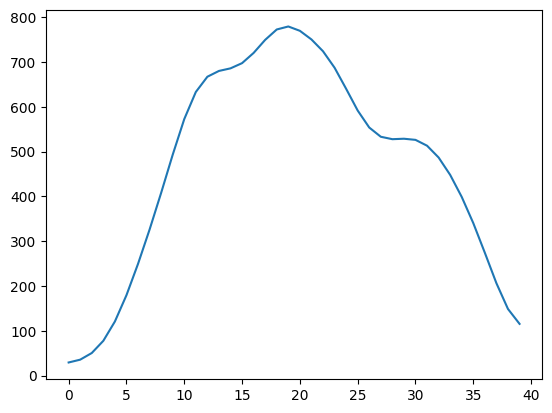

In [105]:
plt.plot(np.sum(heatmap_smooth, axis=1))

sum_heatmap = np.sum(heatmap_smooth, axis=1)
heatmap_smooth[:,sum_heatmap>0.5*np.max(sum_heatmap)].shape


## Section 5: check anticipatory firing

## Check spike phase against distance to goal, as well as ConSink cells

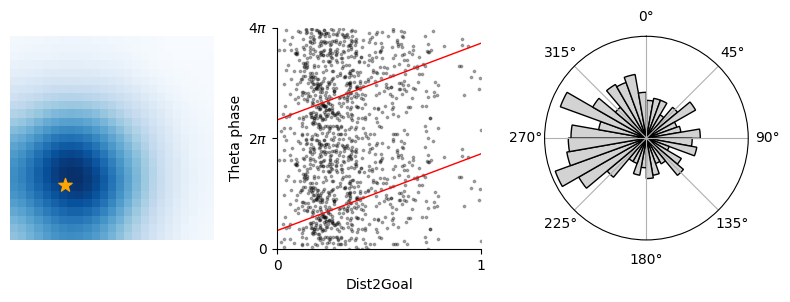

In [13]:
#Vel, Position, goal_loc, pc_activity
pc_activity.shape

# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

addfitline = True

fig = plt.figure(figsize=(8,3), dpi=100)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

cellindex = [20, 20]

ax = plt.subplot(gs[0])
#tuning map of a cell

Position_norm = (Position - Position.min() - 1e-5)/(Position.max() - Position.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')

#mark the goal location
goal_x = (goal_loc[0]- Position.min())/(Position.max() - Position.min())*dim
goal_y = (goal_loc[1]- Position.min())/(Position.max() - Position.min())*dim

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.axis('off')


####################################################################################################

#Phase against distance to goal

ax = plt.subplot(gs[1])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

for i in range(len(Position)):
    #get the distance to goal_loc
    dist_i = np.linalg.norm(Position[i] - goal_loc)
    # dist_i = np.where(dist_i > 0.5, 1.0 - dist_i, dist_i)
    
    #get the vec pointing from Position to goal_loc
    vec = goal_loc - Position[i]
    #get the angle between vec and moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
    angle = np.degrees(angle) % 360
    
    #get the phase at current time step i
    phase_i = theta_phase[i]*np.pi*2
    
    spikes = np.random.poisson(r[i]*dt*1)
    if spikes > 0:
        #save dist_i and phase_i
        Dist2G.append(dist_i)
        SpikePhase.append(phase_i)
        RelativeDirection.append(angle)

Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(-np.pi, np.pi, 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

# ax[0].set_xlabel('Head direction')
ax.set_xlabel('Dist2Goal', fontsize=10)
ax.set_ylabel('Theta phase', fontsize=10)
#activity colorbar
ax.set_xlim(0, 1)
ax.set_xticks([0, 1])
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

sns.despine()

####################################################################################################
#ConSink
ax = plt.subplot(gs[2], projection='polar')
#plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
ax.hist(np.radians(RelativeDirection), bins=36, color='lightgrey', edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
plt.tight_layout()


### plot spike phase against distance to goal for all cells

In [18]:
# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

#for cell index x vary from 0-49 and y vary from 0-49, plot the tuning map and the phase of spikes at each time step

all_clcc = []
all_RelativeDirection = []
for xi in range(15, 35, 2):
    for yi in range(15, 35, 2):
        print('Processing cell index: ', xi, yi)
        cellindex = [xi, yi]

        fig = plt.figure(figsize=(8,3), dpi=100)
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
        
        ####################################################################################################
        ax = plt.subplot(gs[0])
        #plot the tuning map
        Position_norm = (Position - Position.min() - 1e-5)/(Position.max() - Position.min())
        dim = num//2
        tuningMap = get_tuningMap(pc_activity, 
                                    Position_norm, 
                                    cellindex_x=cellindex[0],
                                    cellindex_y=cellindex[1],
                                    shift = 0,
                                    filter=True,
                                    samples_per_sec=1000,
                                    dim=dim)
        ax.imshow(tuningMap, cmap='Blues', origin='lower')

        #mark the goal location
        goal_x = (goal_loc[0]- Position.min())/(Position.max() - Position.min())*dim
        goal_y = (goal_loc[1]- Position.min())/(Position.max() - Position.min())*dim
        ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

        ax.axis('off')


        ####################################################################################################
        #Phase against distance to goal
        ax = plt.subplot(gs[1])
        
        Dist2G = []
        SpikePhase = []
        RelativeDirection = []

        r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

        for i in range(len(Position)):
            #get the distance to goal_loc
            dist_i = np.linalg.norm(Position[i] - goal_loc)
            # dist_i = np.where(dist_i > 0.5, 1.0 - dist_i, dist_i)
  
            #get the vec pointing from Position to goal_loc
            vec = goal_loc - Position[i]
            #get the angle between vec and moving direction
            angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
            angle = np.degrees(angle) % 360
            
            #get the phase at current time step i
            phase_i = theta_phase[i]*np.pi*2
            
            spikes = np.random.poisson(r[i]*dt*50)
            if spikes > 0:
                #save dist_i and phase_i
                Dist2G.append(dist_i)
                SpikePhase.append(phase_i)
                RelativeDirection.append(angle)
                all_RelativeDirection.append(angle)

        Dist2G = np.asarray(Dist2G)
        SpikePhase = np.asarray(SpikePhase)

        ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

        ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

        circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)
        all_clcc.append(circ_lin_corr)
        if True:
            # Plot the circular-linear regression
            x = np.linspace(-np.pi, np.pi, 100)
            y = 2 * np.pi * slope * x + phi0
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 4*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #substrac intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1) 

        # ax[0].set_xlabel('Head direction')
        ax.set_xlabel('Dist2Goal', fontsize=10)
        ax.set_ylabel('Theta phase', fontsize=10)
        #activity colorbar
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_ylim(0, 4*np.pi)
        ax.set_yticks([0, 2*np.pi, 4*np.pi])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

        sns.despine()
        
        ####################################################################################################
        #ConSink
        ax = plt.subplot(gs[2], projection='polar')
        #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
        ax.hist(np.radians(RelativeDirection), bins=36, color='lightgrey', edgecolor='black')
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_yticks([])

        plt.tight_layout()
        
        plt.savefig('./figures/phasevsgoaldist/Cell_'+str(cellindex[0])+'_'+str(cellindex[1])+'.png', dpi=300)
        
        plt.close()

Processing cell index:  15 15
Processing cell index:  15 17
Processing cell index:  15 19
Processing cell index:  15 21
Processing cell index:  15 23
Processing cell index:  15 25


[]

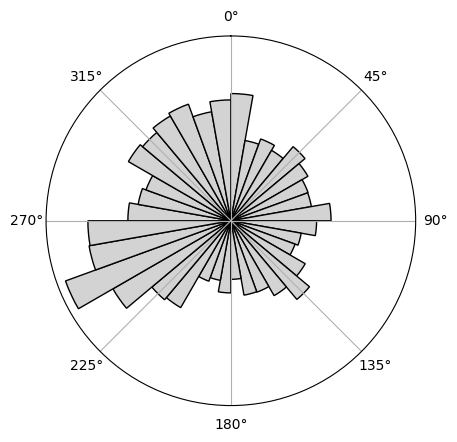

In [7]:
# fig, ax = plt.subplots(1, 1, figsize=(3,3))
#projection = polor
ax = plt.subplot(111, projection='polar')
#plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
ax.hist(np.radians(all_RelativeDirection), bins=36, color='lightgrey', edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])

Wilcoxon signed-rank test: W = 459.000, p = 0.129


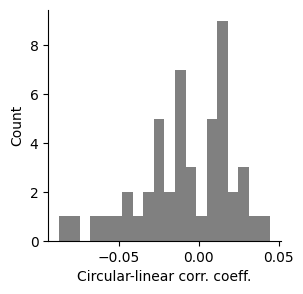

In [17]:
#plot histogram of circ_lin_corr
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=100)
ax.hist(all_clcc, bins=20, color='grey')
ax.set_xlabel('Circular-linear corr. coeff.')
ax.set_ylabel('Count')
sns.despine()

#check if the circular-linear correlation is significantly different from 0 
#using wilcoxon signed-rank test
from scipy.stats import wilcoxon
w, p = wilcoxon(all_clcc)
print('Wilcoxon signed-rank test: W = %.3f, p = %.3f' % (w, p))